# Step 4: Joint star and telluric model

We now combine Steps 1, 2, and 3 to form a joint model for both the star and telluric atmosphere.

In [1]:
import torch
from blase.emulator import (SparseLinearEmulator, SparseLogEmulator, 
                            ExtrinsicModel, InstrumentalModel)
from blase.utils import doppler_grid
import matplotlib.pyplot as plt
import math
%config InlineBackend.figure_format='retina'

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60
wavelength_grid = doppler_grid(wl_lo, wl_hi)

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

We will fetch the pretrained stellar model, following the previous tutorial.

**Step 1:** Clone the stellar spectrum

In [4]:
stellar_pretrained_model = torch.load('phoenix_clone_T4700g4p5_prom0p01_11000Ang.pt')
stellar_emulator = SparseLinearEmulator(wavelength_grid, 
                                        init_state_dict=stellar_pretrained_model)
stellar_emulator.to(device)
stellar_emulator.radial_velocity.data = torch.tensor(+25.1)

Initializing a sparse model with 426 spectral lines


**Step 2:** Clone the Earth's atmosphere spectrum

In [5]:
telluric_pretrained_model = torch.load('telfit_clone_temp290_hum040_prom0p01_11000Ang.pt')
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                        init_state_dict=telluric_pretrained_model)
telluric_emulator.to(device)

Initializing a sparse model with 265 spectral lines


SparseLogEmulator()

**Step 3:** Apply $v\sin{i}$ broadening and RV shifting

In [6]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(1.1)
extrinsic_layer.ln_vsini.data = torch.log(vsini)

Compute the **forward models** at all three steps so far:

In [7]:
stellar_flux = stellar_emulator.forward()
broadened_flux = extrinsic_layer(stellar_flux)
telluric_attenuation = telluric_emulator.forward()

### The Earth's atmosphere predictably attenuates the starlight

Starlight impinges upon the Earth's upper atmosphere as an extrinisically-modulated yet otherwise-pristine high resolution spectrum.  The Earth's atmosphere takes metaphorical bites out of this spectrum **at high spectral resolution**.  

It is this composite stellar spectrum *times* telluric spectrum that arrives through the telescope dome and reflects into the instrument.  We will refer to this flux as the **"flux at the telescope"** to distinguish it from the flux at the *detector*.

**Step 4:** Jointly model the star emergent spectrum and Earth's attenuation.

In [8]:
flux_at_telescope = broadened_flux * telluric_attenuation 

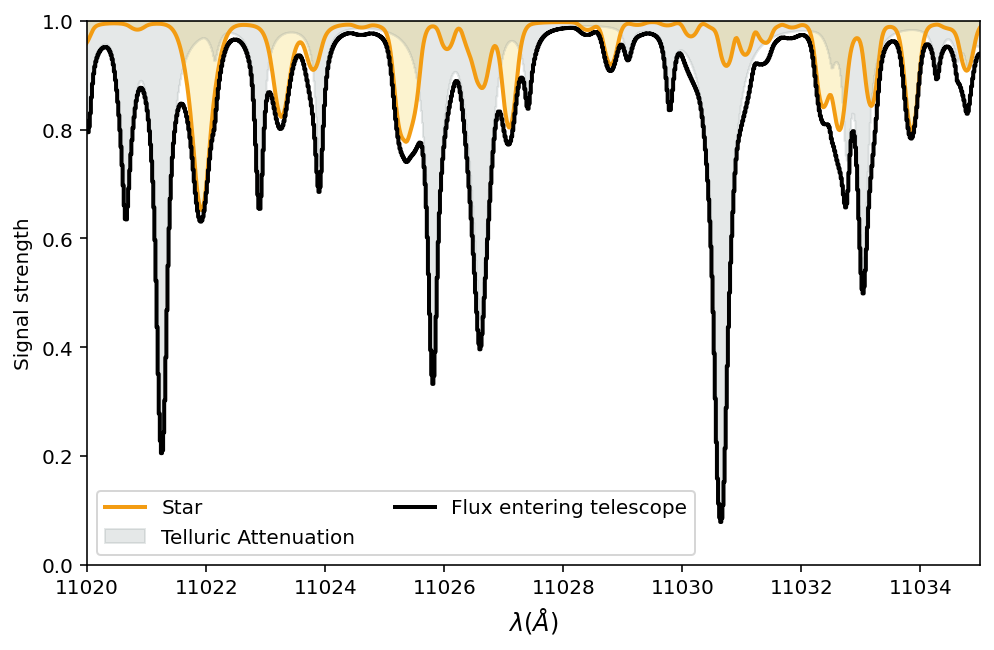

In [9]:
plt.figure(figsize=(8, 5))
plt.fill_between(wavelength_grid, broadened_flux.detach().cpu().numpy(), 1, 
                 alpha=0.2, color='#f1c40f')
plt.plot(wavelength_grid, broadened_flux.detach().cpu().numpy(), color='#f39c12', lw=2, label='Star')
plt.fill_between(wavelength_grid, telluric_attenuation.detach().cpu().numpy(), 1,
                 label='Telluric Attenuation', color='#7f8c8d',alpha=0.2, step='mid')
plt.step(wavelength_grid, flux_at_telescope.detach().cpu().numpy(), 
         label='Flux entering telescope', 
         color='k', lw=2)

plt.xlabel('$\lambda (\AA)$', fontsize=12);plt.ylabel('Signal strength')
plt.xlim(11_020, 11_035); plt.ylim(0, 1.0)
plt.legend(loc='best', ncol=2);

Excellent! The thick black line constitutes the **joint model** of stellar and telluric flux.  In this view, most of the spectral structure arises from telluric lines, and the stellar lines are systematically blurred by their finite $v\sin{i}$.  

In the next tutorial, we will convolve the entire joint model with an instrumental kernel, and then resample it onto wavelength coordinates dictated by a data spectrum.